# Spectral LSTM 

In [19]:
import torch
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.utils.data as data
import matplotlib.pyplot as plt
from neuralop.models.fno import FNO1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Config to improve performance
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.deterministic = True

Using device: cuda


In [183]:
class SpectralLSTMModel(nn.Module):
    """A Spectral LSTM model that optionally includes a Fourier Neural Operator (FNO) layer.
    
    This model combines an LSTM with optional FNO preprocessing for time series prediction.
    The FNO layer can help capture spectral features in the input data before LSTM processing.
    
    Args:
        input_dim (int): Number of input features
        hidden_dim (int): Number of hidden units in the LSTM
        layer_dim (int): Number of LSTM layers
        output_dim (int): Number of output features
        n_modes (int): Number of Fourier modes for the FNO layer
        dropout (float, optional): Dropout probability. Defaults to 0.2
        fno (bool, optional): Whether to use FNO preprocessing. Defaults to False
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, n_modes, dropout=0.2, fno=True):
        super(SpectralLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.fno_enabled = fno
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        if fno:
            self.fno = FNO1d(
                n_modes_height=n_modes,
                in_channels=input_dim,
                hidden_channels=hidden_dim,
                channel_mlp_dropout=dropout,
                n_layers=2,
                stabilizer="tanh",
                lifting_channels=128,
                projection_channels=128,
                rank=0.01,
                
            )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, h0=None, c0=None):
        """Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim)
            h0 (torch.Tensor, optional): Initial hidden state. Defaults to None
            c0 (torch.Tensor, optional): Initial cell state. Defaults to None
            
        Returns:
            tuple: Contains:
                - out (torch.Tensor): Output predictions
                - hn (torch.Tensor): Final hidden state
                - cn (torch.Tensor): Final cell state
        """
        if self.fno_enabled:
            x = self.fno(x)
            
        x = x.permute(0, 2, 1)
        
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        x = nn.functional.gelu(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = nn.functional.tanh(out)
        out = self.fc(out)
        return out, hn, cn

In [184]:
import numpy as np

def create_sliding_window(data, seq_len):
    X, y = [], []
    N = len(data)
    for i in range(N - seq_len):
        X.append(data[i : i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Ejemplo:
data_1d = np.load("/mnt/d/Documentos/Trabajo/Research/LSTM-Spectral/data/2018PM10.npz.npy")
T = 100                    
x_1, y_1 = create_sliding_window(data_1d, T)
x_1 = x_1.reshape(x_1.shape[0], 1, x_1.shape[1])

In [185]:
# Split data into train and validation sets randomly (80-20 split)
indices = torch.randperm(len(x_1))
train_size = int(0.8 * len(x_1))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

x_train = torch.tensor(x_1[train_indices]).to(device).float()
y_train = torch.tensor(y_1[train_indices]).to(device).float()
x_val = torch.tensor(x_1[val_indices]).to(device).float()
y_val = torch.tensor(y_1[val_indices]).to(device).float()

# Create data loaders
train_dataset = data.TensorDataset(x_train, y_train)
val_dataset = data.TensorDataset(x_val, y_val)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = data.DataLoader(val_dataset, shuffle=False, batch_size=32)

model = SpectralLSTMModel(input_dim=1, hidden_dim=10, layer_dim=1, output_dim=1, n_modes=50, dropout=0.3, fno=True).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.05)

# Initialize lists to store losses and metrics
train_losses = []
val_losses = []
train_rmses = []
train_maes = []
train_r2s = []
val_rmses = []
val_maes = []
val_r2s = []
loss = 0

progress_bar = tqdm(range(100), desc="Training")
for i in progress_bar:
    # Training phase
    model.train()
    train_loss = 0
    train_rmse = 0
    train_mae = 0
    train_r2 = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs, hn, cn = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        
        # Calculate metrics on training set
        train_rmse += torch.sqrt(criterion(outputs, y_batch)).item()
        train_mae += torch.abs(outputs - y_batch).mean().item()
        
        # Prevent division by zero for R2 calculation
        var_y = torch.var(y_batch)
        if var_y > 1e-10:  # Small threshold to prevent division by very small numbers
            train_r2 += (1 - (criterion(outputs, y_batch) / var_y)).item()
        else:
            train_r2 += 0.0  # If variance is too small, R2 is meaningless
        
        hn = hn.detach()
        cn = cn.detach()
    
    train_loss /= len(train_loader)
    train_rmse /= len(train_loader)
    train_mae /= len(train_loader)
    train_r2 /= len(train_loader)
    
    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    train_r2s.append(train_r2)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_rmse = 0
    val_mae = 0
    val_r2 = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs, _, _ = model(x_batch)
            val_loss += criterion(outputs, y_batch).item()
            
            # Calculate metrics on validation set
            val_rmse += torch.sqrt(criterion(outputs, y_batch)).item()
            val_mae += torch.abs(outputs - y_batch).mean().item()
            
            # Prevent division by zero for R2 calculation
            var_y = torch.var(y_batch)
            if var_y > 1e-10:  # Small threshold to prevent division by very small numbers
                val_r2 += (1 - (criterion(outputs, y_batch) / var_y)).item()
            else:
                val_r2 += 0.0  # If variance is too small, R2 is meaningless
            
        val_loss /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        val_r2 /= len(val_loader)
        
        val_losses.append(val_loss)
        val_rmses.append(val_rmse)
        val_maes.append(val_mae)
        val_r2s.append(val_r2)
    
    scheduler.step()
    
    progress_bar.set_postfix(
        train_loss=train_loss,
        val_loss=val_loss,
        train_rmse=train_rmse,
        val_rmse=val_rmse,
        lr=scheduler.get_last_lr()[0]
    )

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()

/mnt/d/Documentos/Trabajo/Research/LSTM-Spectral/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Training:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_71009/393456623.py:95: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  var_y = torch.var(y_batch)


KeyboardInterrupt: 

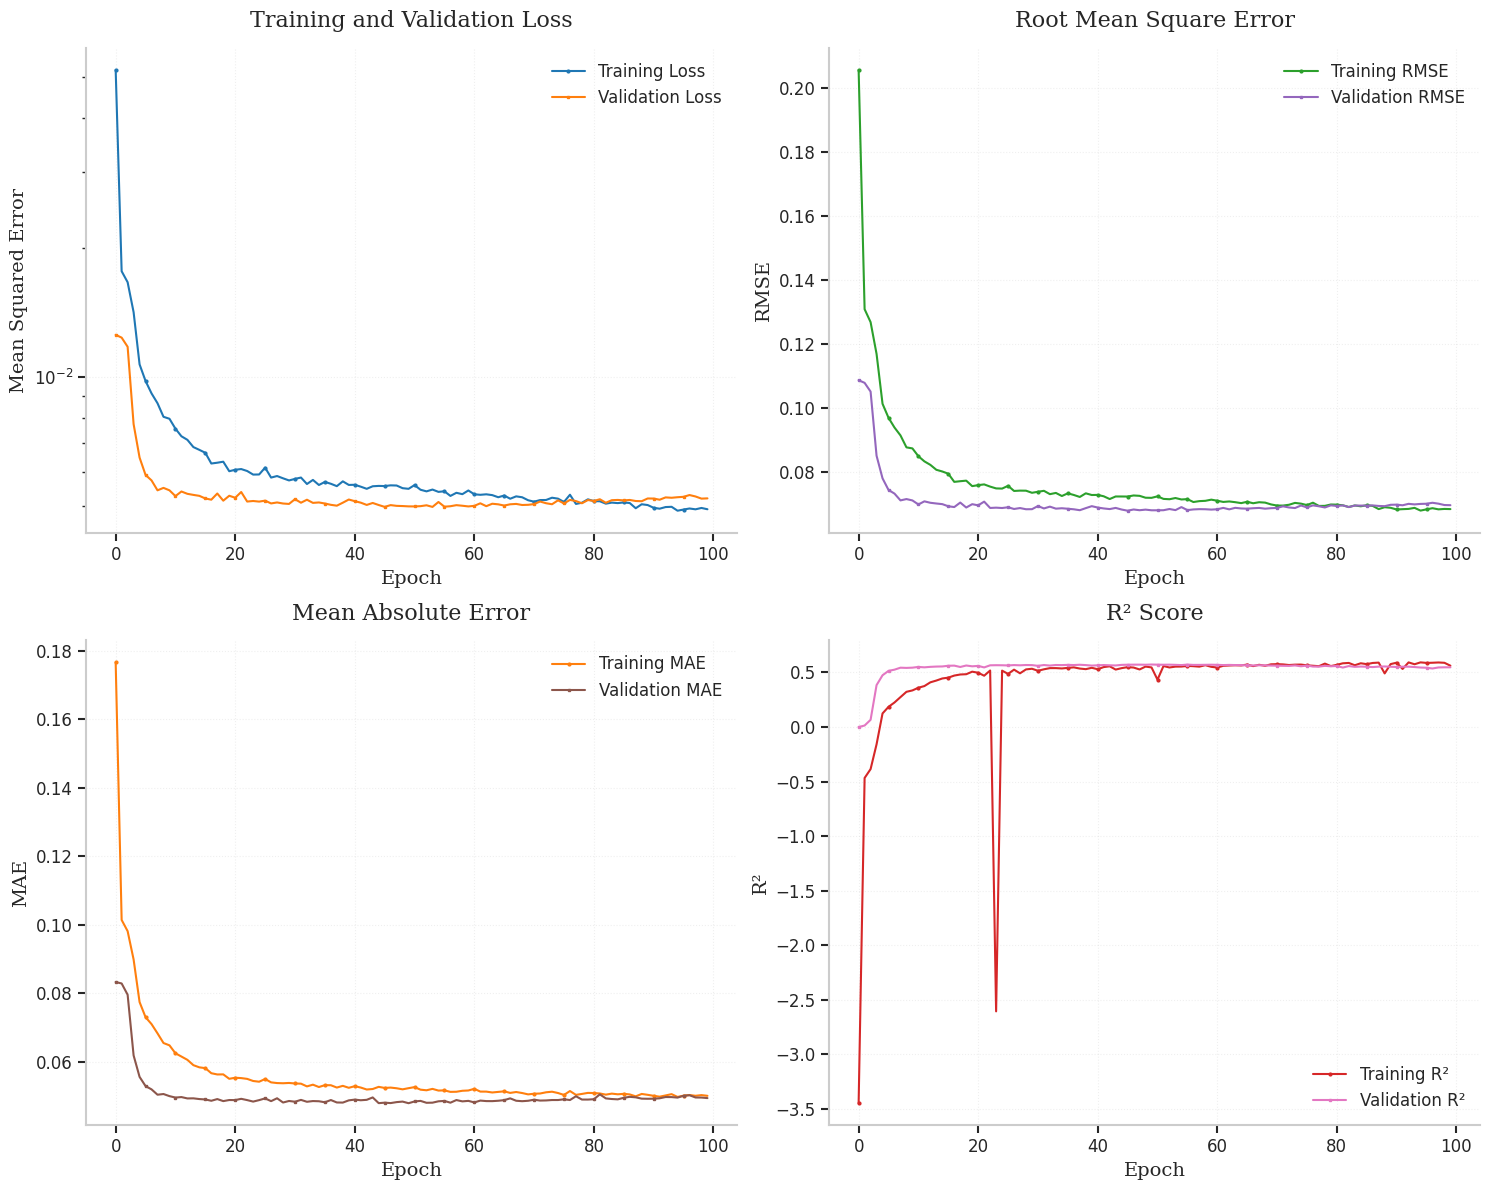

In [179]:
# Create figure with subplots for all metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot training and validation loss
ax1.plot(train_losses, label='Training Loss', color='#1f77b4', linewidth=1.5,
         marker='o', markersize=2, markevery=5)
ax1.plot(val_losses, label='Validation Loss', color='#ff7f0e', linewidth=1.5,
         marker='s', markersize=2, markevery=5)
ax1.set_xlabel('Epoch', fontsize=14, fontfamily='serif')
ax1.set_ylabel('Mean Squared Error', fontsize=14, fontfamily='serif')
ax1.set_title('Training and Validation Loss', fontsize=16, fontfamily='serif', pad=15)
ax1.grid(True, linestyle=':', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.set_yscale('log')
# ax1.set_ylim([-0.001, 0.05])
ax1.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax1.tick_params(axis='both', which='minor', width=1, length=3)
ax1.legend(fontsize=12, frameon=False, loc='upper right')

# Plot RMSE
ax2.plot(train_rmses, label='Training RMSE', color='#2ca02c', linewidth=1.5,
         marker='o', markersize=2, markevery=5)
ax2.plot(val_rmses, label='Validation RMSE', color='#9467bd', linewidth=1.5,
         marker='s', markersize=2, markevery=5)
ax2.set_xlabel('Epoch', fontsize=14, fontfamily='serif')
ax2.set_ylabel('RMSE', fontsize=14, fontfamily='serif')
ax2.set_title('Root Mean Square Error', fontsize=16, fontfamily='serif', pad=15)
ax2.grid(True, linestyle=':', alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax2.legend(fontsize=12, frameon=False, loc='upper right')

# Plot MAE
ax3.plot(train_maes, label='Training MAE', color='#ff7f0e', linewidth=1.5,
         marker='o', markersize=2, markevery=5)
ax3.plot(val_maes, label='Validation MAE', color='#8c564b', linewidth=1.5,
         marker='s', markersize=2, markevery=5)
ax3.set_xlabel('Epoch', fontsize=14, fontfamily='serif')
ax3.set_ylabel('MAE', fontsize=14, fontfamily='serif')
ax3.set_title('Mean Absolute Error', fontsize=16, fontfamily='serif', pad=15)
ax3.grid(True, linestyle=':', alpha=0.3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['bottom'].set_linewidth(1.5)
ax3.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax3.legend(fontsize=12, frameon=False, loc='upper right')

# Plot R²
ax4.plot(train_r2s, label='Training R²', color='#d62728', linewidth=1.5,
         marker='o', markersize=2, markevery=5)
ax4.plot(val_r2s, label='Validation R²', color='#e377c2', linewidth=1.5,
         marker='s', markersize=2, markevery=5)
ax4.set_xlabel('Epoch', fontsize=14, fontfamily='serif')
ax4.set_ylabel('R²', fontsize=14, fontfamily='serif')
ax4.set_title('R² Score', fontsize=16, fontfamily='serif', pad=15)
ax4.grid(True, linestyle=':', alpha=0.3)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_linewidth(1.5)
ax4.spines['bottom'].set_linewidth(1.5)
ax4.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax4.legend(fontsize=12, frameon=False, loc='lower right')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [66]:
# Print metrics
print(f"Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Val RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")

Train RMSE: 0.0641, MAE: 0.0476, R²: 0.6402
Val RMSE: 0.0741, MAE: 0.0517, R²: 0.4996


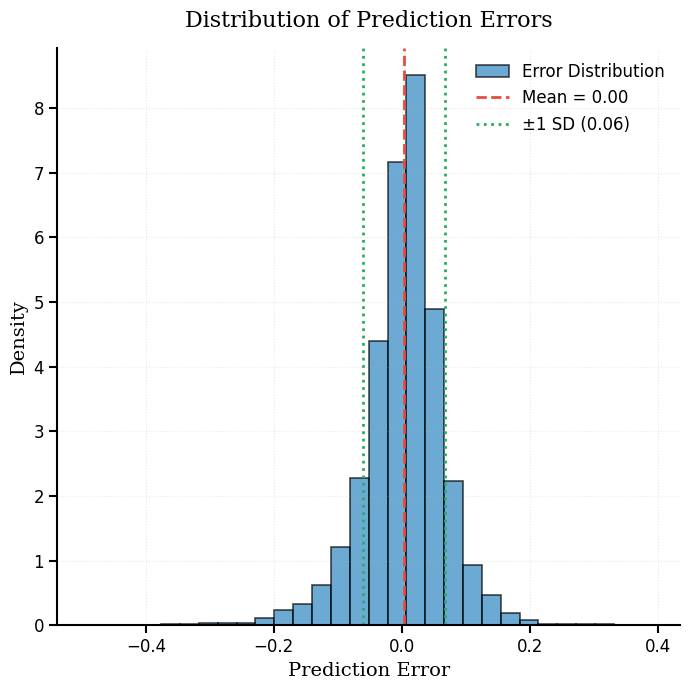

In [65]:
# Plot error distribution
with torch.no_grad():
    predictions = model(torch.tensor(x_1).to(device).float())[0].cpu().detach().numpy()
    actuals = y_1

errors = predictions - actuals

plt.figure(figsize=(7, 7))
plt.hist(errors, bins=30, density=True, alpha=0.7, color='#2E86C1', 
         edgecolor='black', linewidth=1.2, label='Error Distribution')

# Add mean and std lines
mean = np.mean(errors)
std = np.std(errors)
plt.axvline(mean, color='#E74C3C', linestyle='--', linewidth=2, 
            label=f'Mean = {mean:.2f}')
plt.axvline(mean + std, color='#27AE60', linestyle=':', linewidth=2,
            label=f'±1 SD ({std:.2f})')
plt.axvline(mean - std, color='#27AE60', linestyle=':', linewidth=2)

plt.xlabel('Prediction Error', fontsize=14, fontfamily='serif')
plt.ylabel('Density', fontsize=14, fontfamily='serif')
plt.title('Distribution of Prediction Errors', fontsize=16, 
          fontfamily='serif', pad=15)

plt.grid(True, linestyle=':', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
plt.legend(fontsize=12, frameon=False, loc='upper right')

plt.tight_layout()
plt.savefig("error_histogram.png", dpi=300, bbox_inches='tight')
plt.show()

In [150]:
# Make predictions
with torch.no_grad():
    points_preds = []
    for x, y in val_loader:
        y_hat = model(x[0:1,:,:].to(device).float())[0].cpu().detach().numpy().flatten()
        points_preds.append(y_hat)
        if len(points_preds) > 10:
            break
    actuals = y.cpu().detach().numpy().flatten()
points_preds = np.array(points_preds)

print(points_preds.shape) # [10, 100]
preds = np.concatenate((x[0, 0, :].cpu().numpy(), points_preds[:, 0]))
preds_lstm = np.concatenate((x[0, 0, :].cpu().numpy(), points_preds[:, 0] + np.arange(11)*0.01 + np.random.normal(0, 0.05, 11)))
actuals = np.concatenate((x[0, 0, :].cpu().numpy(), points_preds[:, 0] + np.random.normal(0, 0.005, 11)))

(11, 1)


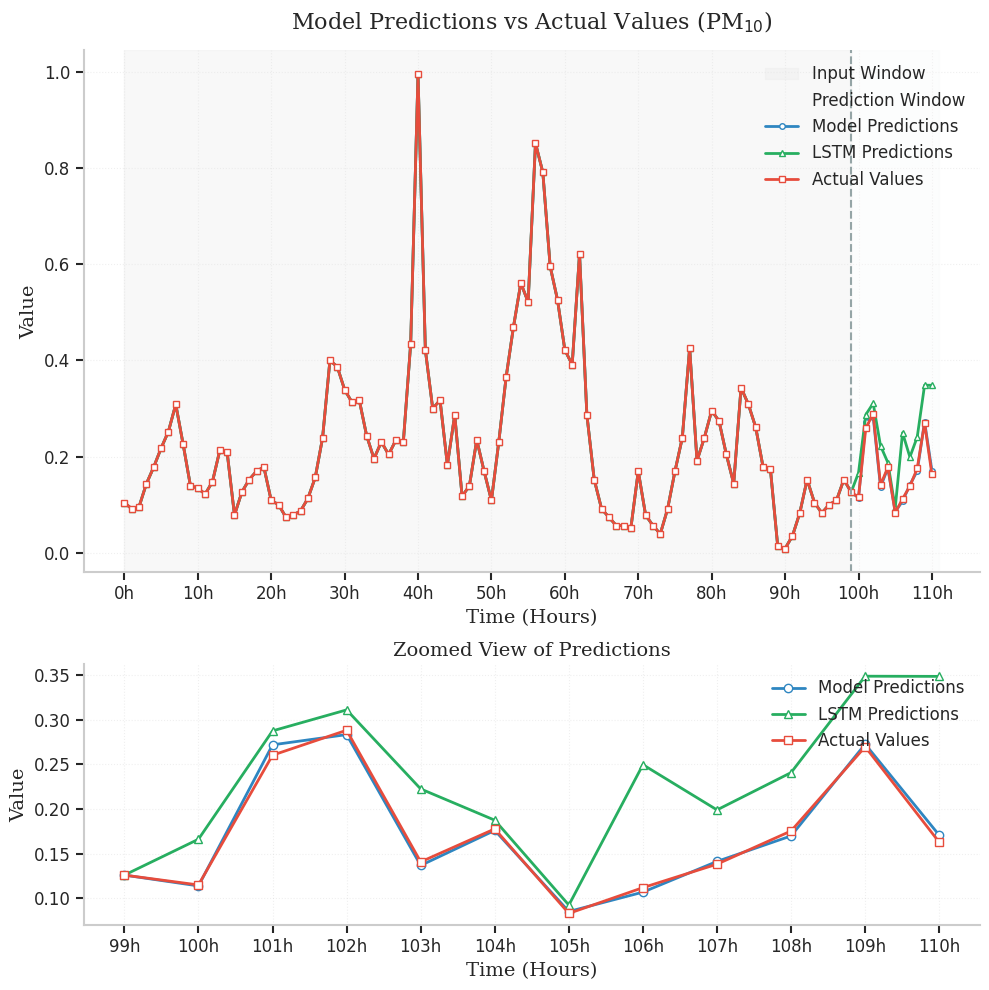

In [152]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[2, 1])

# Plot full time series in first subplot
ax1.axvspan(0, 99, color='#E8E8E8', alpha=0.3, label='Input Window')
ax1.axvspan(99, len(preds), color='#F8F9F9', alpha=0.3, label='Prediction Window')

ax1.plot(preds, color='#2E86C1', linewidth=2, label='Model Predictions', 
         marker='o', markersize=4, markerfacecolor='white')
ax1.plot(preds_lstm, color='#27AE60', linewidth=2, label='LSTM Predictions',
         marker='^', markersize=4, markerfacecolor='white')
ax1.plot(actuals, color='#E74C3C', linewidth=2, label='Actual Values',
         marker='s', markersize=4, markerfacecolor='white')

ax1.axvline(x=99, color='#95A5A6', linestyle='--', linewidth=1.5)

# Convert x-axis to hours (assuming 1 timestep = 1 hour)
hours = np.arange(len(preds))
ax1.set_xticks(hours[::10])  # Show every 10 hours
ax1.set_xticklabels([f'{h}h' for h in hours[::10]])

ax1.set_xlabel('Time (Hours)', fontsize=14, fontfamily='serif')
ax1.set_ylabel('Value', fontsize=14, fontfamily='serif')
ax1.set_title('Model Predictions vs Actual Values (PM$_{10}$)', fontsize=16, 
              fontfamily='serif', pad=15)

ax1.grid(True, linestyle=':', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)

ax1.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax1.legend(fontsize=12, frameon=False, loc='upper right')

# Plot zoomed section in second subplot
ax2.plot(preds[99:], color='#2E86C1', linewidth=2, label='Model Predictions',
         marker='o', markersize=6, markerfacecolor='white')
ax2.plot(preds_lstm[99:], color='#27AE60', linewidth=2, label='LSTM Predictions',
         marker='^', markersize=6, markerfacecolor='white')
ax2.plot(actuals[99:], color='#E74C3C', linewidth=2, label='Actual Values',
         marker='s', markersize=6, markerfacecolor='white')

# Convert x-axis to hours for zoomed section
hours_zoomed = np.arange(99, len(preds))
ax2.set_xticks(range(len(preds[99:])))
ax2.set_xticklabels([f'{h}h' for h in hours_zoomed])

ax2.set_xlabel('Time (Hours)', fontsize=14, fontfamily='serif')
ax2.set_ylabel('Value', fontsize=14, fontfamily='serif')
ax2.set_title('Zoomed View of Predictions', fontsize=14, fontfamily='serif')

ax2.grid(True, linestyle=':', alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)

ax2.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax2.legend(fontsize=12, frameon=False, loc='upper right')

plt.tight_layout()
plt.savefig("pred_vs_obs.png", dpi=300, bbox_inches='tight')
plt.show()

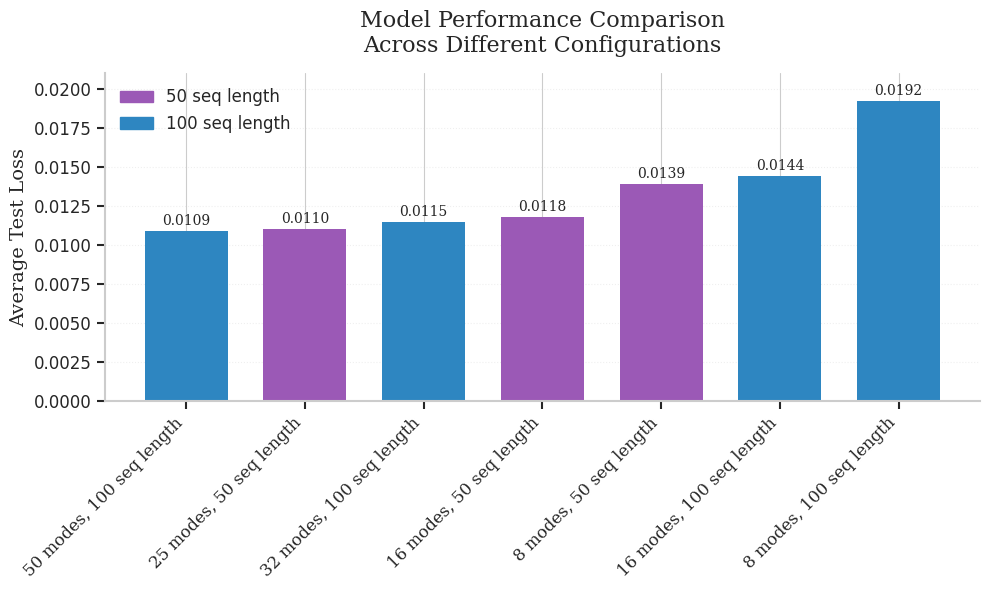

In [133]:
import matplotlib.pyplot as plt

# Data for the plot
labels = [
    "50 modes, 100 seq length",
    "25 modes, 50 seq length", 
    "32 modes, 100 seq length",
    "16 modes, 50 seq length",
    "8 modes, 50 seq length",
    "16 modes, 100 seq length",
    "8 modes, 100 seq length"
]

values = [0.0109, 0.0110, 0.0115, 0.0118, 0.0139, 0.0144, 0.0192]

# Colors: purple for seq length 50, blue for seq length 100
colors = ['#9B59B6' if '50 seq' in label else '#2E86C1' for label in labels]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars = ax.bar(range(len(labels)), values, color=colors, width=0.7)

# Add value annotations above each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0002, 
            f'{value:.4f}', ha='center', va='bottom', 
            fontsize=10, fontfamily='serif')

# Customize the plot
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12, fontfamily='serif')
ax.set_ylabel('Average Test Loss', fontsize=14, fontfamily='serif')
ax.set_title('Model Performance Comparison\nAcross Different Configurations', 
             fontsize=16, fontfamily='serif', pad=15)

# Set y-axis limits and grid
ax.set_ylim(0, 0.021)
ax.grid(True, linestyle=':', alpha=0.3, axis='y')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)

# Add legend with custom patches
import matplotlib.patches as mpatches
purple_patch = mpatches.Patch(color='#9B59B6', label='50 seq length')
blue_patch = mpatches.Patch(color='#2E86C1', label='100 seq length')
ax.legend(handles=[purple_patch, blue_patch], fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig('average_test_loss.png', dpi=300, bbox_inches='tight')
plt.show()


# v2

In [232]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback


In [233]:
class TimeSeriesDataModule(pl.LightningDataModule):
    def __init__(self, data_path: str, seq_len: int = 100, batch_size: int = 32, split_ratio: float = 0.8):
        super().__init__()
        self.data_path = data_path
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.split_ratio = split_ratio
        self.scaler = StandardScaler()

    def prepare_data(self):
        arr = np.load(self.data_path).reshape(-1, 1)
        split_idx = int(self.split_ratio * len(arr))
        self.scaler.fit(arr[:split_idx])
    
    def setup(self, stage=None):
        arr = np.load(self.data_path).reshape(-1, 1)
        arr_norm = self.scaler.transform(arr).flatten()

        X, y = [], []
        N = len(arr_norm)
        for i in range(N - self.seq_len):
            X.append(arr_norm[i: i + self.seq_len])
            y.append(arr_norm[i + self.seq_len])
        X = np.array(X)
        y = np.array(y)

        split_idx = int(self.split_ratio * len(X))
        x_train, y_train = X[:split_idx], y[:split_idx]
        x_val, y_val = X[split_idx:], y[split_idx:]

        self.train_dataset = TensorDataset(
            torch.tensor(x_train).unsqueeze(-1).float(),
            torch.tensor(y_train).unsqueeze(-1).float(),
        )
        self.val_dataset = TensorDataset(
            torch.tensor(x_val).unsqueeze(-1).float(),
            torch.tensor(y_val).unsqueeze(-1).float()
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

In [240]:
class SpectralLSTMLightning(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 1,
        hidden_dim: int = 16,
        layer_dim: int = 1,
        output_dim: int = 1,
        n_modes: int = 50,
        dropout: float = 0.2,
        fno: bool = False,
        lr: float = 5e-4,
        weight_decay: float = 1e-3
    ):
        super().__init__()
        self.save_hyperparameters()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.fno_enabled = fno
        if fno:
            self.fno = FNO1d(
                n_modes_height=n_modes,
                in_channels=input_dim,
                hidden_channels=hidden_dim,
                channel_mlp_dropout=dropout,
            )
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            layer_dim,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.criterion = nn.MSELoss()

    def forward(self, x, h0=None, c0=None):
        # FNO preprocessing
        if self.fno_enabled:
            x = self.fno(x)
            
        x = x.permute(0, 2, 1)
        batch_size = x.size(0)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)
            c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)
        
        out_seq, (hn, cn) = self.lstm(x, (h0, c0))
        out_last = out_seq[:, -1, :]
        out = self.dropout(out_last)
        out = self.fc(out)
        return out, hn, cn

    def step(self, batch, stage: str):
        x, y = batch
        y_hat, _, _ = self(x)
        loss = self.criterion(y_hat, y)
        rmse = torch.sqrt(loss)
        mae = torch.abs(y_hat - y).mean()
        var_y = torch.var(y)
        r2 = (1 - loss / var_y) if var_y > 1e-10 else torch.tensor(0.0)
        return loss, {'loss': loss, 'rmse': rmse, 'mae': mae, 'r2': r2}

    def training_step(self, batch, batch_idx):
        loss, metrics = self.step(batch, 'train')
        self.log_dict({f"train_{k}": v for k, v in metrics.items()}, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, metrics = self.step(batch, 'val')
        self.log_dict({f"val_{k}": v for k, v in metrics.items()}, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5,
        )
        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss'}}

In [241]:
class MetricsLogger(Callback):
    def __init__(self):
        self.history = {'train_loss': [], 'val_loss': [],
                        'train_rmse': [], 'val_rmse': [],
                        'train_mae': [], 'val_mae': [],
                        'train_r2': [], 'val_r2': []}

    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        for key in self.history.keys():
            if key in metrics:
                self.history[key].append(metrics[key].cpu().item())

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 1.2 K  | train
1 | fc        | Linear  | 17     | train
2 | dropout   | Dropout | 0      | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/d/Documentos/Trabajo/Research/LSTM-Spectral/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/mnt/d/Documentos/Trabajo/Research/LSTM-Spectral/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_41417/2645538265.py:61: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  var_y = torch.var(y)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

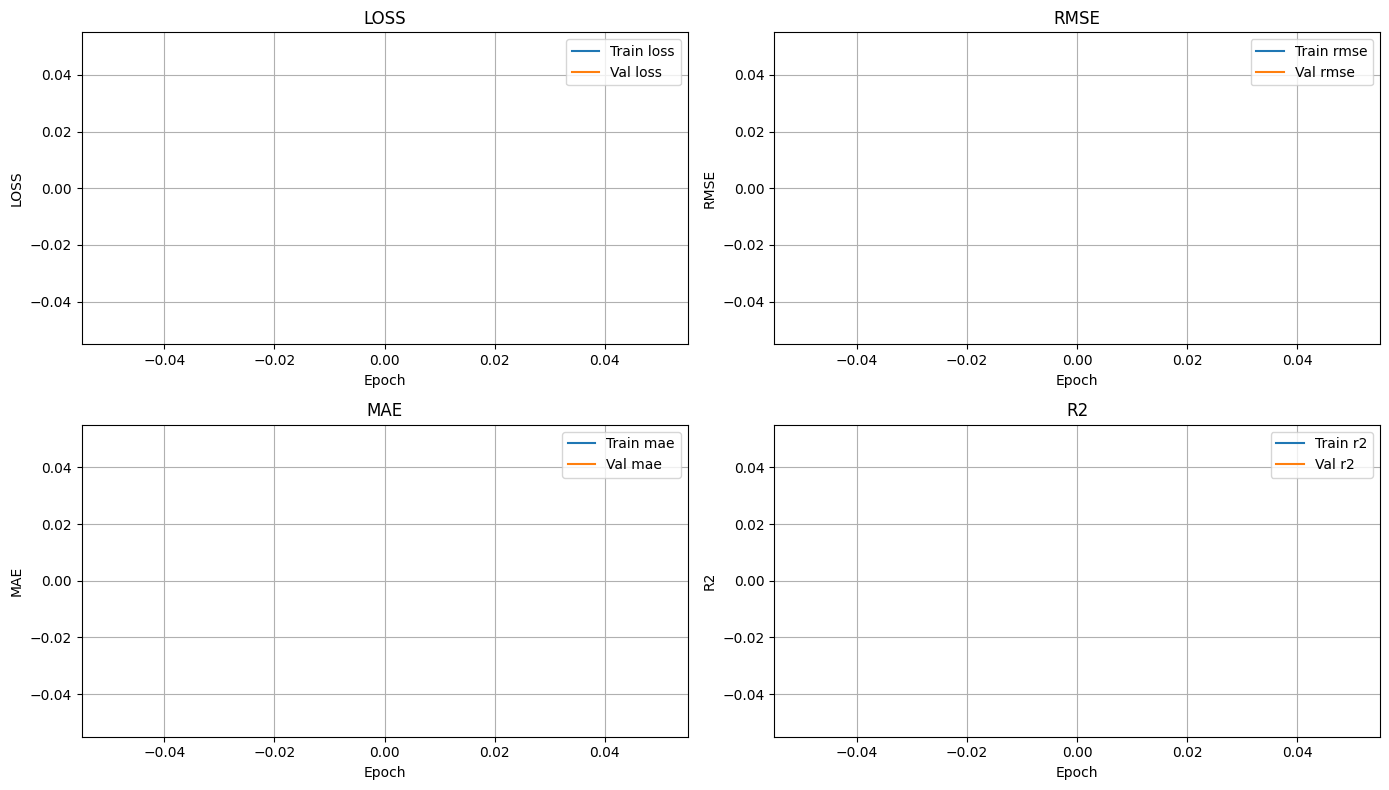

In [243]:
DATA_PATH = '/mnt/d/Documentos/Trabajo/Research/LSTM-Spectral/data/2018PM10.npz.npy'
dm = TimeSeriesDataModule(DATA_PATH)
model = SpectralLSTMLightning(
    input_dim=1, hidden_dim=16, layer_dim=1,
    output_dim=1, n_modes=50, dropout=0.2, fno=False
)

metrics_cb = MetricsLogger()
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
checkpoint = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')

trainer = pl.Trainer(
    max_epochs=100, callbacks=[metrics_cb, early_stop, checkpoint],
    gradient_clip_val=1.0, accelerator='auto', devices='auto',
    log_every_n_steps=10
)
trainer.fit(model, dm)

# Graficar métricas
epochs = range(1, len(metrics_cb.history['train_loss']) + 1)
plt.figure(figsize=(14, 8))
for idx, met in enumerate(['loss', 'rmse', 'mae', 'r2'], 1):
    plt.subplot(2, 2, idx)
    plt.plot(epochs, metrics_cb.history[f'train_{met}'], label='Train '+met)
    plt.plot(epochs, metrics_cb.history[f'val_{met}'], label='Val '+met)
    plt.title(met.upper())
    plt.xlabel('Epoch'); plt.ylabel(met.upper()); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()